## Flow over Cylinder

In [3]:
import os
import math
import numpy as np
from scipy import integrate
from matplotlib import pyplot as py
%matplotlib inline

In [4]:
u_inf = 1.0

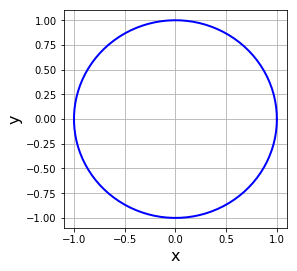

In [7]:
R = 1.0
x_center, y_center = 0.0, 0.0
theta = np.linspace(0.0, 2 * math.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                          y_center + R * np.sin(theta))

# plot the cylinder
size = 4
py.figure(figsize=(size, size))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
py.xlim(-1.1, 1.1)
py.ylim(-1.1, 1.1);

In [10]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya +yb) / 2
        self.length = math.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        
        #orientation of the panel
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb- ya) / self.length)
            
        self.sigma = 0.0 #source strength
        self.vt = 0.0 #tangential velocity
        self.cp = 0.0 #pressure coefficient

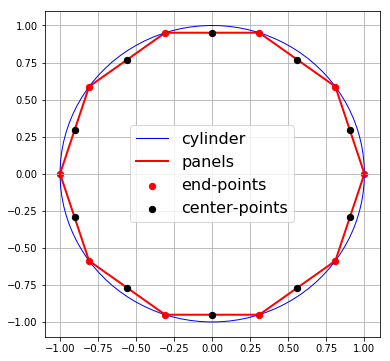

In [11]:
N_panels = 10

#define end points
x_ends = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

#define the panels
panels = np.empty(N_panels, dtype = object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i +1], y_ends[i + 1])
    
#plot the panels
size = 6
py.figure(figsize = (size, size))
py.grid()
py.plot(x_cylinder, y_cylinder,
            label='cylinder',
            color='b', linestyle='-', linewidth=1)
py.plot(x_ends, y_ends,
            label='panels',
            color='r', linestyle='-', linewidth=2)
py.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points',
               color='r', s=40)
py.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points',
               color='k', s=40, zorder=3)
py.legend(loc='best', prop={'size':16})
py.xlim(-1.1, 1.1)
py.ylim(-1.1, 1.1);

In [12]:
def integral_normal(p_i, p_j):
    
    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
               ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
               (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [15]:
#compute the source influence matrix
A = np.empty((N_panels, N_panels), dtype = float)
np.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i !=j:
            A[i, j] = 0.5 / math.pi * integral_normal(p_i, p_j)
            
            
b = -u_inf * np.cos([p.beta for p in panels])

In [16]:
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [17]:
def integral_tangential(p_i, p_j):

    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [19]:
A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / math.pi * integral_tangential(p_i, p_j)

# compute the right hand side
b = - u_inf * np.sin([panel.beta for panel in panels])

# compute the tangential velocity at each panel center-point
vt = np.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [21]:
#compute pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt / u_inf)**2

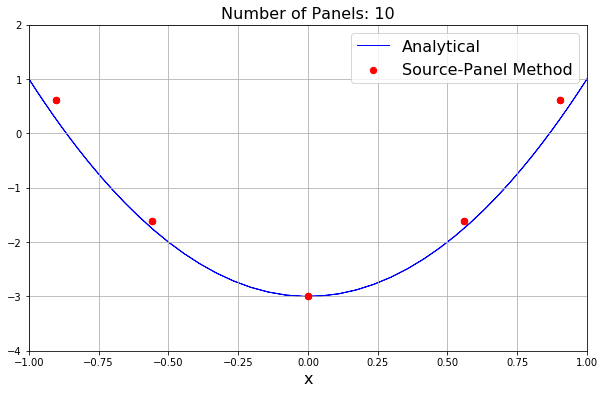

In [23]:
cp_analytical = 1.0 - 4 * (y_cylinder / R)**2

#plot the surface pressure coefficint
py.figure(figsize=(10,6))
py.grid()
py.xlabel('x', fontsize = 16)
py.plot(x_cylinder, cp_analytical,
       label='Analytical',
       color='b', linestyle='-', linewidth = 1, zorder =1)
py.scatter([p.xc for p in panels], [p.cp for p in panels],
          label='Source-Panel Method',
          color='r', s=40, zorder=2)
py.title('Number of Panels: %d' %N_panels, fontsize=16)
py.legend(loc='best', prop={'size':16})
py.xlim(-1.0,1.0)
py.ylim(-4.0, 2.0);